In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("/kaggle/input/insurance/insurance.csv")
df["sex"]    = (df["sex"] == "male").astype(int)
df["smoker"] = (df["smoker"] == "yes").astype(int)
df = pd.get_dummies(df, columns=["region"], drop_first=True)
df["age_bmi"]    = df["age"] * df["bmi"]
df["smoker_bmi"] = df["bmi"] * df["smoker"]
df["log_charges"] = np.log1p(df["charges"])

X = df.drop(columns=["charges", "log_charges"])
y_log = df["log_charges"]
y_true = df["charges"]

# 1. Загрузка и подготовка данных 
# Читаем датасет страховых выплат и кодируем категориальные признаки в числовые.
# Формирование признаков и целевой переменной 
# X — все признаки, y_log — логарифмированные значения charges, y_true — исходные charges для обратной трансформации.

In [3]:
X_train, X_test, y_train_log, y_test_log, y_train_true, y_test_true = train_test_split(
    X, y_log, y_true, test_size=0.2, random_state=42
)


preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), X.columns)
])
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled  = preprocessor.transform(X_test)


params = {
    "booster": ["dart"],
    "n_estimators": [200, 400],
    "max_depth": [4, 6],
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1],
}

xgb = XGBRegressor(
    reg_alpha=0.5,
    reg_lambda=0.5,
    random_state=42,
    verbosity=0
)

gs = GridSearchCV(
    xgb,
    params,
    cv=3,
    n_jobs=-1,
    scoring="neg_mean_absolute_error",
    verbose=2
)
gs.fit(X_train_scaled, y_train_log)

print("Лучшие параметры:", gs.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Лучшие параметры: {'booster': 'dart', 'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1}


# 2. Train/Test Split и масштабирование 
# Делим выборку 80/20 и масштабируем признаки для ускорения сходимости бустинга.
# Инициализация и обучение XGBoost DART 
# Используем booster="dart" с ранней остановкой и метрикой MAE. eval_set обеспечивает доступ к learning curve.

In [8]:
best_xgb = XGBRegressor(
    booster="dart",
    n_estimators=200,
    learning_rate=0.03,
    max_depth=4,
    subsample=1,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5,
    random_state=42,
    eval_metric="mae",             
    early_stopping_rounds=20,        
    verbosity=1
)

best_xgb.fit(
    X_train_scaled, y_train_log,
    eval_set=[(X_train_scaled, y_train_log), (X_test_scaled, y_test_log)],
    verbose=False
)
y_pred_train = np.expm1(best_xgb.predict(X_train_scaled))
y_pred_test  = np.expm1(best_xgb.predict(X_test_scaled))

print("\n== TRAIN ==")
print("MAE:", mean_absolute_error(y_train_true, y_pred_train))
print("R2: ", r2_score(y_train_true, y_pred_train))

print("\n== TEST ==")
print("MAE:", mean_absolute_error(y_test_true, y_pred_test))
print("R2: ", r2_score(y_test_true, y_pred_test))


== TRAIN ==
MAE: 1822.3098760831995
R2:  0.8814432806476953

== TEST ==
MAE: 1929.922715456565
R2:  0.8814783770752557


# 3. Предсказания и обратное логарифмирование
# Прогнозируем логарифмы, затем восстанавливаем реальные значения страховых выплат.
# Метрики качества модели
# Оцениваем производительность по MAE, RMSE и R² для train и test.

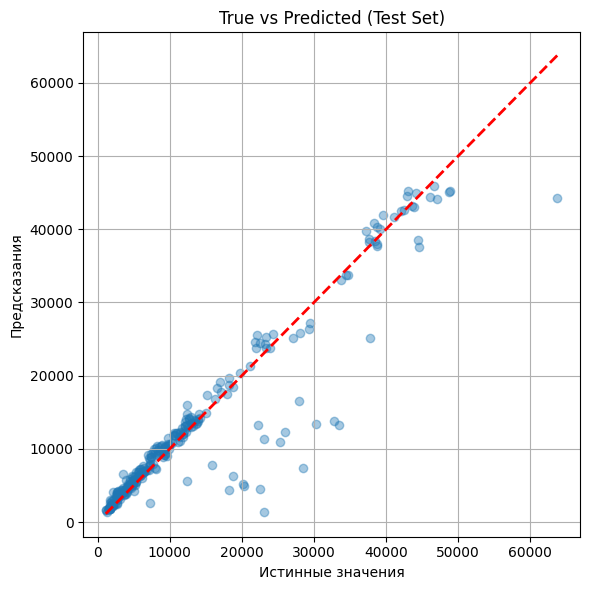

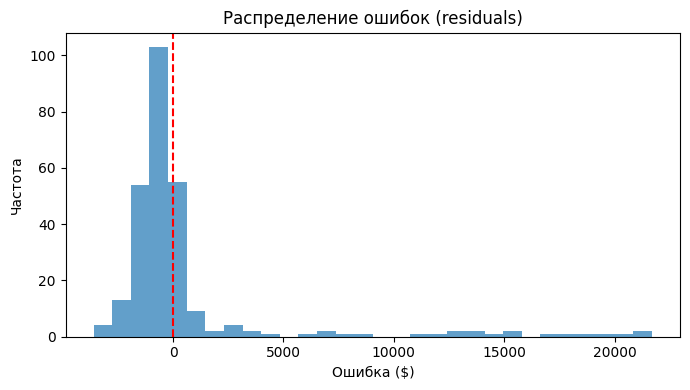

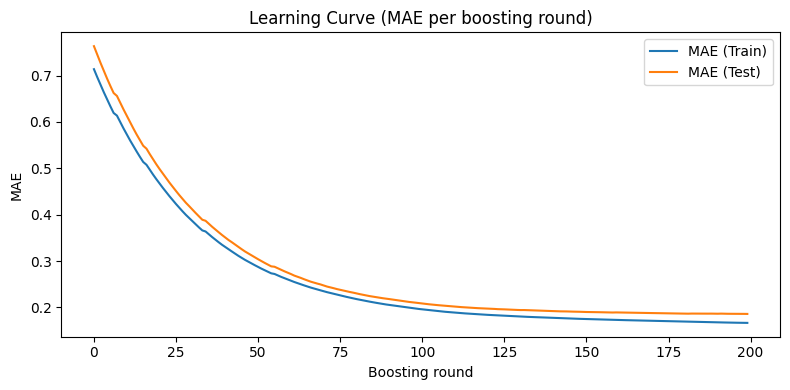

[CV] END booster=dart, colsample_bytree=0.8, learning_rate=0.03, max_depth=4, n_estimators=200, subsample=1; total time=   4.0s
[CV] END booster=dart, colsample_bytree=0.8, learning_rate=0.03, max_depth=4, n_estimators=400, subsample=0.8; total time=  14.8s
[CV] END booster=dart, colsample_bytree=0.8, learning_rate=0.03, max_depth=4, n_estimators=400, subsample=1; total time=  15.6s
[CV] END booster=dart, colsample_bytree=0.8, learning_rate=0.03, max_depth=6, n_estimators=400, subsample=0.8; total time=  15.3s
[CV] END booster=dart, colsample_bytree=0.8, learning_rate=0.03, max_depth=6, n_estimators=400, subsample=1; total time=  16.0s
[CV] END booster=dart, colsample_bytree=0.8, learning_rate=0.05, max_depth=4, n_estimators=400, subsample=1; total time=  14.7s
[CV] END booster=dart, colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.8; total time=   4.0s
[CV] END booster=dart, colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=200, su

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_true, y_pred_test, alpha=0.4)
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'r--', lw=2)
plt.xlabel("Истинные значения")
plt.ylabel("Предсказания")
plt.title("True vs Predicted (Test Set)")
plt.grid()
plt.tight_layout()
plt.show()


errors = y_test_true - y_pred_test
plt.figure(figsize=(7,4))
plt.hist(errors, bins=30, alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Распределение ошибок (residuals)")
plt.xlabel("Ошибка ($)")
plt.ylabel("Частота")
plt.tight_layout()
plt.show()


if hasattr(best_xgb, 'evals_result'):
    evals_result = best_xgb.evals_result()
    if "validation_0" in evals_result and "mae" in evals_result["validation_0"]:
        plt.figure(figsize=(8,4))
        plt.plot(evals_result['validation_0']['mae'], label='MAE (Train)')
        if "validation_1" in evals_result and "mae" in evals_result["validation_1"]:
            plt.plot(evals_result['validation_1']['mae'], label='MAE (Test)')
        plt.xlabel("Boosting round")
        plt.ylabel("MAE")
        plt.title("Learning Curve (MAE per boosting round)")
        plt.legend()
        plt.tight_layout()
        plt.show()